In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import joblib
from lib.loader import SingleFileExtractor, FolderExtractor, Segment
from scipy.signal import savgol_filter
import tensorflow as tf
import scipy.signal as ss

In [3]:
# ==== Parametry ====
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
BATCH_SIZE = 64
LATENT_DIM = 8
EPOCHS = 10
BETA = 1e-3
MODEL_DIR = "models"
MAX_SAMPLES = 36000
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
# ==== Sekvencer ====
class CreathonSegmentSequence(Sequence):
    def __init__(self, segments, window_size=500, batch_size=64, normalize=True):
        self.window_size = window_size
        self.batch_size = batch_size
        self.normalize = normalize
        self.windows = []
        self.data_mean = None
        self.data_std = None

        all_data = np.concatenate([seg.data for seg in segments if seg.data is not None and len(seg.data) >= window_size])
        self.data_mean = np.nanmean(all_data)
        self.data_std = np.nanstd(all_data) + 1e-8

        for seg in segments:
            if seg.data is None or len(seg.data) < window_size:
                continue
            data = seg.data
            if normalize:
                data = (data - self.data_mean) / self.data_std
            for i in range(len(data) - window_size + 1):
                window = data[i:i + window_size]
                if np.isnan(window).any():
                    continue
                self.windows.append(window)

        self.windows = np.array(self.windows)[..., np.newaxis]

    def __len__(self):
        return len(self.windows) // self.batch_size

    def __getitem__(self, idx):
        batch = self.windows[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch, batch

# ==== Pomocné funkce ====
def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_sequence_from_single_file(file_path, annotations_path, signal_name="icp",
                                   window_size=500, batch_size=64, use_anomalous=False):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)

    good, anom = extractor.extract(signal_name)
    segments = good + anom if use_anomalous else good

    # Omez segmenty na ty s omezeným počtem vzorků (MAX_SAMPLES)
    limited_segments = []
    total_samples = 0
    for seg in segments:
        if seg.data is None:
            continue
        if total_samples >= MAX_SAMPLES:
            break
        seg_length = len(seg.data)
        if total_samples + seg_length > MAX_SAMPLES:
            seg.data = seg.data[:MAX_SAMPLES - total_samples]  # zkrátit
        limited_segments.append(seg)
        total_samples += len(seg.data)

    extractor.load_data(limited_segments)
    return CreathonSegmentSequence(limited_segments, window_size, batch_size)


In [5]:

# ==== Sampling layer ====
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ==== Encoder ====
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(WINDOW_SIZE, 1))
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# ==== Decoder ====
def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(500, activation="relu")(inputs)
    x = layers.Reshape((500, 1))(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(1, 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

# ==== VAE ====
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [149]:
# ==== Trénování ====
encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

last_sequence = None

all_files = get_file_paths(HDF_PATH)
if all_files:
    file_path = all_files[0]
    print(f"Trénuji na prvním souboru: {os.path.basename(file_path)}")
    sequence = load_sequence_from_single_file(
        file_path=file_path,
        annotations_path=HDF_PATH,
        signal_name=SIGNAL_NAME,
        window_size=WINDOW_SIZE,
        batch_size=BATCH_SIZE,
        use_anomalous=False
    )
    if len(sequence) > 0:
        vae.fit(sequence, epochs=EPOCHS)
        last_sequence = sequence

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_2.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_2.keras"))


Trénuji na prvním souboru: TBI_001_v2_1_2_20.hdf5
Epoch 1/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - kl_loss: 5.3173 - loss: 0.1674 - recon_loss: 0.1621
Epoch 2/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - kl_loss: 3.8293 - loss: 0.0176 - recon_loss: 0.0138
Epoch 3/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.7452 - loss: 0.0138 - recon_loss: 0.0101
Epoch 4/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - kl_loss: 3.7310 - loss: 0.0112 - recon_loss: 0.0075
Epoch 5/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.7065 - loss: 0.0103 - recon_loss: 0.0066
Epoch 6/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.6846 - loss: 0.0098 - recon_loss: 0.0061
Epoch 7/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - kl_loss: 3.6736 - loss: 0.0093 - recon_loss: 0.0057
Epoch 8/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.6630 - loss: 0.0089 - recon_loss: 0.0053
Epoch 9/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - kl_loss: 3.6

In [150]:
def plot_generation(n_samples=3):
    random_latents = tf.random.normal((n_samples, LATENT_DIM))
    generated = vae.decoder(random_latents).numpy()
    if last_sequence:
        generated = generated * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.plot(generated[i].squeeze())
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

def plot_reconstruction():
    if not last_sequence:
        print("Nebyla nalezena žádná trénovací sekvence.")
        return
    X, _ = last_sequence[0]
    recon = vae.decoder(vae.encoder(X)[2]).numpy()
    X = X * last_sequence.data_std + last_sequence.data_mean
    recon = recon * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(3, 2, i * 2 + 1)
        plt.plot(X[i].squeeze(), label="Original")
        plt.legend()
        plt.subplot(3, 2, i * 2 + 2)
        plt.plot(recon[i].squeeze(), label="Reconstruction")
        plt.legend()
    plt.tight_layout()
    plt.show()


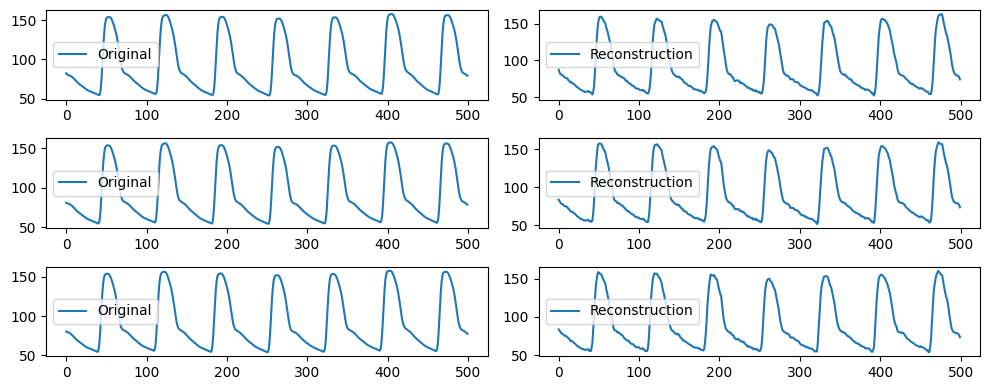

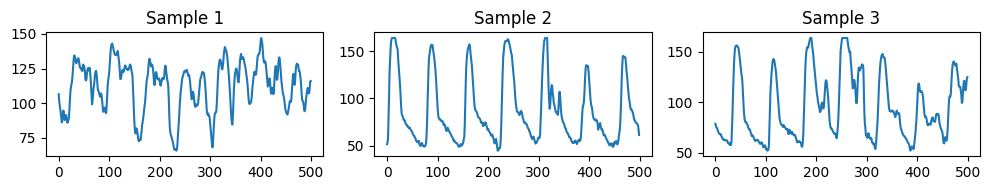

In [151]:
plot_reconstruction()
plot_generation(3)

tf.Tensor(
[[ 0.77814895 -1.933262    1.301155    2.0327208  -1.4338195   0.43253228
  -1.0418106   2.2555099 ]
 [ 1.0494128  -0.23867235 -1.1318799   1.739465   -0.73795754  1.1980554
   0.3487135  -1.1787727 ]
 [ 0.85537416 -0.033776    1.806343   -0.18494332  0.37077934 -0.09283227
  -0.53133255 -0.6625748 ]], shape=(3, 8), dtype=float32)


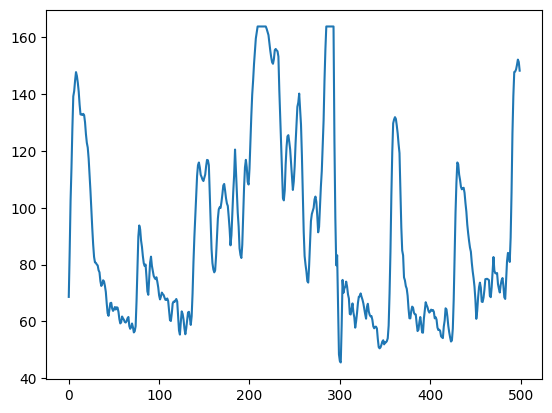

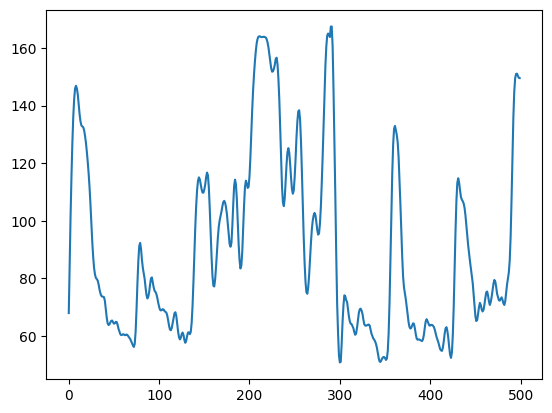

In [165]:
random_latents = tf.random.normal((3, LATENT_DIM))
print(random_latents)
generated = vae.decoder(random_latents).numpy()
generated = generated * last_sequence.data_std + last_sequence.data_mean

plt.plot(generated[0].squeeze())
plt.show()
plt.plot(savgol_filter(generated[0].squeeze(), 9, 3))
plt.show()

In [ ]:
encoder = load_model("models/vae_encoder_hour.keras", compile=False, custom_objects={"Sampling": Sampling})
decoder = load_model("models/vae_decoder_hour.keras", compile=False)

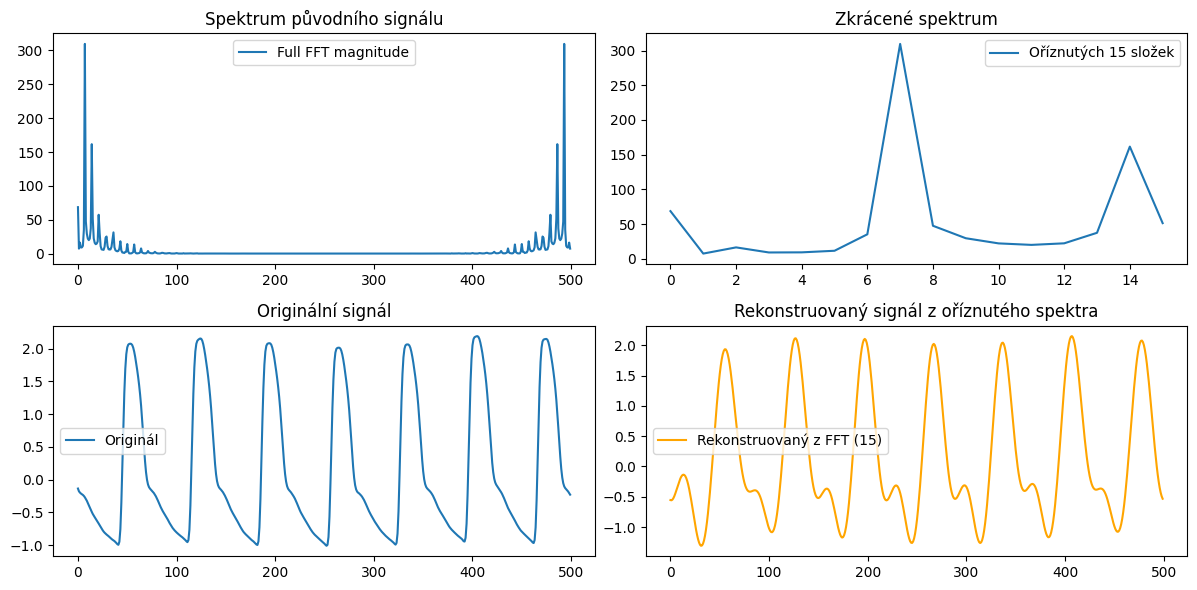

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_from_partial_fft(signal, keep=25):
    """
    Vstup:
        signal - 1D pole, reálný signál
        keep - počet nízkofrekvenčních složek, které si chceme ponechat

    Výstup:
        reconstructed - rekonstruovaný signál z částečného spektra
        fft_full - původní spektrum
        fft_trimmed - oříznuté spektrum
    """
    L = len(signal)
    fft_full = np.fft.fft(signal)

    # Zachovej jen N složek (bez střední a koncové harmonické)
    fft_trimmed = fft_full[:keep].copy()

    # Zrekonstruuj symetrické spektrum (Hermitovské – pro reálný časový signál)
    fft_new = np.zeros(L, dtype=complex)
    fft_new[:keep] = fft_trimmed
    fft_new[-keep+1:] = np.conj(fft_trimmed[1:][::-1])  # symetrie bez DC

    # Inverse FFT
    reconstructed = np.fft.ifft(fft_new)

    return reconstructed.real, fft_full, fft_trimmed


# === DEMO: použití na první segment ze sekvenceru ===
file_path = all_files[0]
sequence = load_sequence_from_single_file(
    file_path=file_path,
    annotations_path=HDF_PATH,
    signal_name=SIGNAL_NAME,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    use_anomalous=False
)

original_signal = sequence.windows[0].squeeze()

# Rekonstrukce
reconstructed, fft_full, fft_cut = reconstruct_from_partial_fft(original_signal, keep=16)

# === VIZUALIZACE ===
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(np.abs(fft_full), label="Full FFT magnitude")
plt.title("Spektrum původního signálu")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.abs(fft_cut), label="Oříznutých 15 složek")
plt.title("Zkrácené spektrum")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(original_signal, label="Originál")
plt.title("Originální signál")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(reconstructed, label="Rekonstruovaný z FFT (15)", color="orange")
plt.title("Rekonstruovaný signál z oříznutého spektra")
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lib.loader import SingleFileExtractor, FolderExtractor, Segment

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
OUTPUT_HDF5 = "spectrum/spectra_analysis.hdf5"
N_COMPONENTS = 100

# === POMOCNÉ FUNKCE ===
def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    all_data = np.concatenate([seg.data for seg in segments if seg.data is not None])
    return all_data

def compute_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            spectrum = np.abs(fft_vals[:n_components])
            spectra.append(spectrum)
    return np.array(spectra)

# === HLAVNÍ ANALÝZA ===
all_files = get_file_paths(HDF_PATH)
if not all_files:
    raise FileNotFoundError("Nebyl nalezen žádný HDF5 soubor v cílové složce.")

# Ověření a vytvoření cílové složky
output_dir = os.path.dirname(OUTPUT_HDF5) or "."
os.makedirs(output_dir, exist_ok=True)

with h5py.File(OUTPUT_HDF5, "w") as f:
    for file_path in all_files:
        print(f"Zpracovávám: {os.path.basename(file_path)}")
        try:
            signal = load_signal(file_path, HDF_PATH, SIGNAL_NAME)
            spectra = compute_spectra(signal, window_size=WINDOW_SIZE, n_components=N_COMPONENTS)
            dataset_name = os.path.splitext(os.path.basename(file_path))[0]
            f.create_dataset(dataset_name, data=spectra, dtype="float32")
        except Exception as e:
            print(f"Chyba při zpracování {file_path}: {e}")

print(f"Spektrální analýza dokončena. Výsledky uloženy v {OUTPUT_HDF5}.")


Zpracovávám: TBI_001_v2_1_2_20.hdf5
Zpracovávám: TBI_001_v2_1_3_6.hdf5
Zpracovávám: TBI_002_v4_2_5_5.hdf5
Zpracovávám: TBI_002_v4_2_7_8.hdf5
Zpracovávám: TBI_003_v2_2_1_0.hdf5
Zpracovávám: TBI_003_v2_2_1_5.hdf5
Zpracovávám: TBI_004b_v2_1_2_16.hdf5
Zpracovávám: TBI_004b_v2_1_3_6.hdf5
Zpracovávám: TBI_005_v2_2_2_19.hdf5
Zpracovávám: TBI_007_v3_1_2_17.hdf5
Zpracovávám: TBI_001_v2_1_2_5.hdf5
Zpracovávám: TBI_002_v4_2_5_20.hdf5
Zpracovávám: TBI_002_v4_2_7_6.hdf5
Zpracovávám: TBI_003_v2_2_1_7.hdf5
Zpracovávám: TBI_003_v2_2_1_8.hdf5
Zpracovávám: TBI_004b_v2_1_2_4.hdf5
Zpracovávám: TBI_005_v2_2_1_12.hdf5
Zpracovávám: TBI_007_v3_1_2_23.hdf5
Zpracovávám: TBI_001_v2_3_5_10.hdf5
Zpracovávám: TBI_001_v2_4_3_16.hdf5
Zpracovávám: TBI_002_v4_2_2_2.hdf5
Zpracovávám: TBI_003_v2_2_1_6.hdf5
Zpracovávám: TBI_003_v2_2_1_9.hdf5
Zpracovávám: TBI_004b_v2_1_2_2.hdf5
Zpracovávám: TBI_004b_v2_1_2_5.hdf5
Zpracovávám: TBI_005_v2_3_3_16.hdf5
Zpracovávám: TBI_007_v3_1_2_18.hdf5
Zpracovávám: TBI_011_v2_2_1_22.hdf5
Zpr

In [2]:
# === UKÁZKOVÝ LOADER STRUKTURY ===
def inspect_hdf5_structure(hdf5_path):
    with h5py.File(hdf5_path, "r") as f:
        print("\nStruktura HDF5 souboru:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"- Dataset: {name}, shape={obj.shape}, dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"- Group: {name}")
        f.visititems(print_structure)

        print("\nUkázka hodnot z prvního datasetu:")
        first_key = list(f.keys())[0]
        print(f"→ Dataset: {first_key}")
        print(f[first_key][:5])  # prvních 5 spekter

# Spusť inspekci
inspect_hdf5_structure(OUTPUT_HDF5)


Struktura HDF5 souboru:
- Dataset: TBI_001_v2_1_2_20, shape=(720, 100), dtype=float32
- Dataset: TBI_001_v2_1_2_5, shape=(706, 100), dtype=float32
- Dataset: TBI_001_v2_1_3_6, shape=(688, 100), dtype=float32
- Dataset: TBI_001_v2_3_5_10, shape=(614, 100), dtype=float32
- Dataset: TBI_001_v2_4_3_16, shape=(664, 100), dtype=float32
- Dataset: TBI_002_v4_2_2_2, shape=(718, 100), dtype=float32
- Dataset: TBI_002_v4_2_5_20, shape=(716, 100), dtype=float32
- Dataset: TBI_002_v4_2_5_5, shape=(692, 100), dtype=float32
- Dataset: TBI_002_v4_2_7_6, shape=(720, 100), dtype=float32
- Dataset: TBI_002_v4_2_7_8, shape=(706, 100), dtype=float32
- Dataset: TBI_003_v2_2_1_0, shape=(718, 100), dtype=float32
- Dataset: TBI_003_v2_2_1_5, shape=(714, 100), dtype=float32
- Dataset: TBI_003_v2_2_1_6, shape=(714, 100), dtype=float32
- Dataset: TBI_003_v2_2_1_7, shape=(702, 100), dtype=float32
- Dataset: TBI_003_v2_2_1_8, shape=(652, 100), dtype=float32
- Dataset: TBI_003_v2_2_1_9, shape=(624, 100), dtype=flo

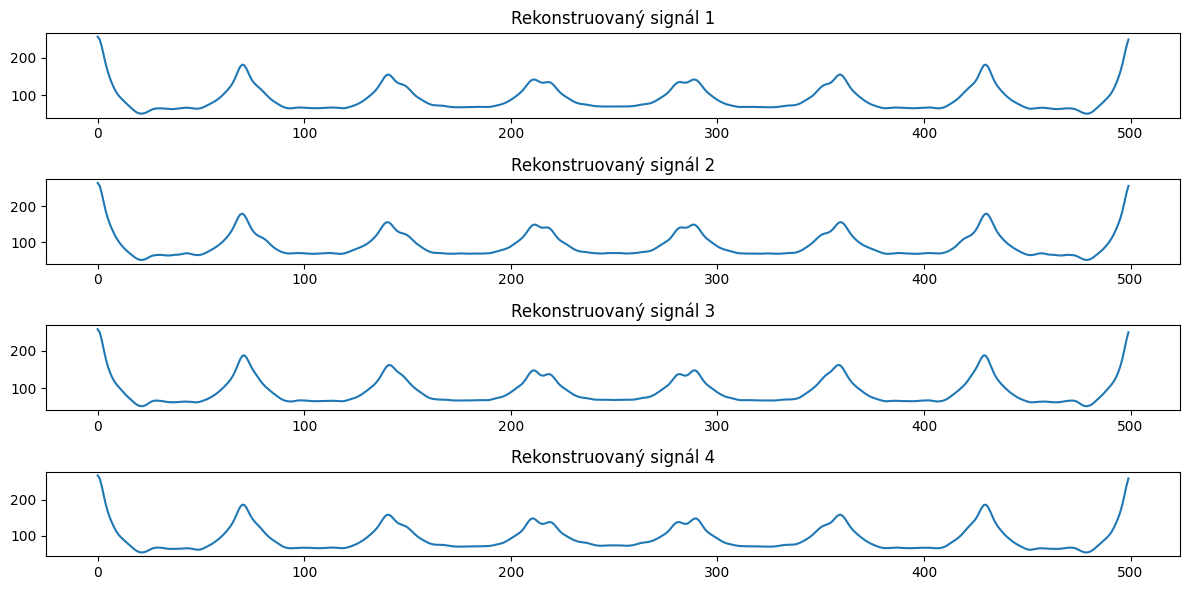

In [3]:
# === REKONSTRUKCE SPEKTER ===
def reconstruct_signals_from_spectra(hdf5_path, n=4, window_size=500):
    with h5py.File(hdf5_path, "r") as f:
        first_key = list(f.keys())[0]
        spectra = f[first_key][:n]

    reconstructed_signals = []
    for spectrum in spectra:
        full_spectrum = np.zeros(window_size, dtype=complex)
        full_spectrum[:len(spectrum)] = spectrum
        full_spectrum[-len(spectrum)+1:] = np.conj(spectrum[1:][::-1])
        signal = np.fft.ifft(full_spectrum).real
        reconstructed_signals.append(signal)

    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(reconstructed_signals):
        plt.subplot(n, 1, i+1)
        plt.plot(signal)
        plt.title(f"Rekonstruovaný signál {i+1}")
    plt.tight_layout()
    plt.show()

# Spusť rekonstrukci
reconstruct_signals_from_spectra(OUTPUT_HDF5, n=4, window_size=WINDOW_SIZE)

Zpracovávám: TBI_001_v2_1_2_20.hdf5
Zpracovávám: TBI_001_v2_1_3_6.hdf5
Zpracovávám: TBI_002_v4_2_5_5.hdf5
Zpracovávám: TBI_002_v4_2_7_8.hdf5
Zpracovávám: TBI_003_v2_2_1_0.hdf5
Zpracovávám: TBI_003_v2_2_1_5.hdf5
Zpracovávám: TBI_004b_v2_1_2_16.hdf5
Zpracovávám: TBI_004b_v2_1_3_6.hdf5
Zpracovávám: TBI_005_v2_2_2_19.hdf5
Zpracovávám: TBI_007_v3_1_2_17.hdf5
Zpracovávám: TBI_001_v2_1_2_5.hdf5
Zpracovávám: TBI_002_v4_2_5_20.hdf5
Zpracovávám: TBI_002_v4_2_7_6.hdf5
Zpracovávám: TBI_003_v2_2_1_7.hdf5
Zpracovávám: TBI_003_v2_2_1_8.hdf5
Zpracovávám: TBI_004b_v2_1_2_4.hdf5
Zpracovávám: TBI_005_v2_2_1_12.hdf5
Zpracovávám: TBI_007_v3_1_2_23.hdf5
Zpracovávám: TBI_001_v2_3_5_10.hdf5
Zpracovávám: TBI_001_v2_4_3_16.hdf5
Zpracovávám: TBI_002_v4_2_2_2.hdf5
Zpracovávám: TBI_003_v2_2_1_6.hdf5
Zpracovávám: TBI_003_v2_2_1_9.hdf5
Zpracovávám: TBI_004b_v2_1_2_2.hdf5
Zpracovávám: TBI_004b_v2_1_2_5.hdf5
Zpracovávám: TBI_005_v2_3_3_16.hdf5
Zpracovávám: TBI_007_v3_1_2_18.hdf5
Zpracovávám: TBI_011_v2_2_1_22.hdf5
Zpr

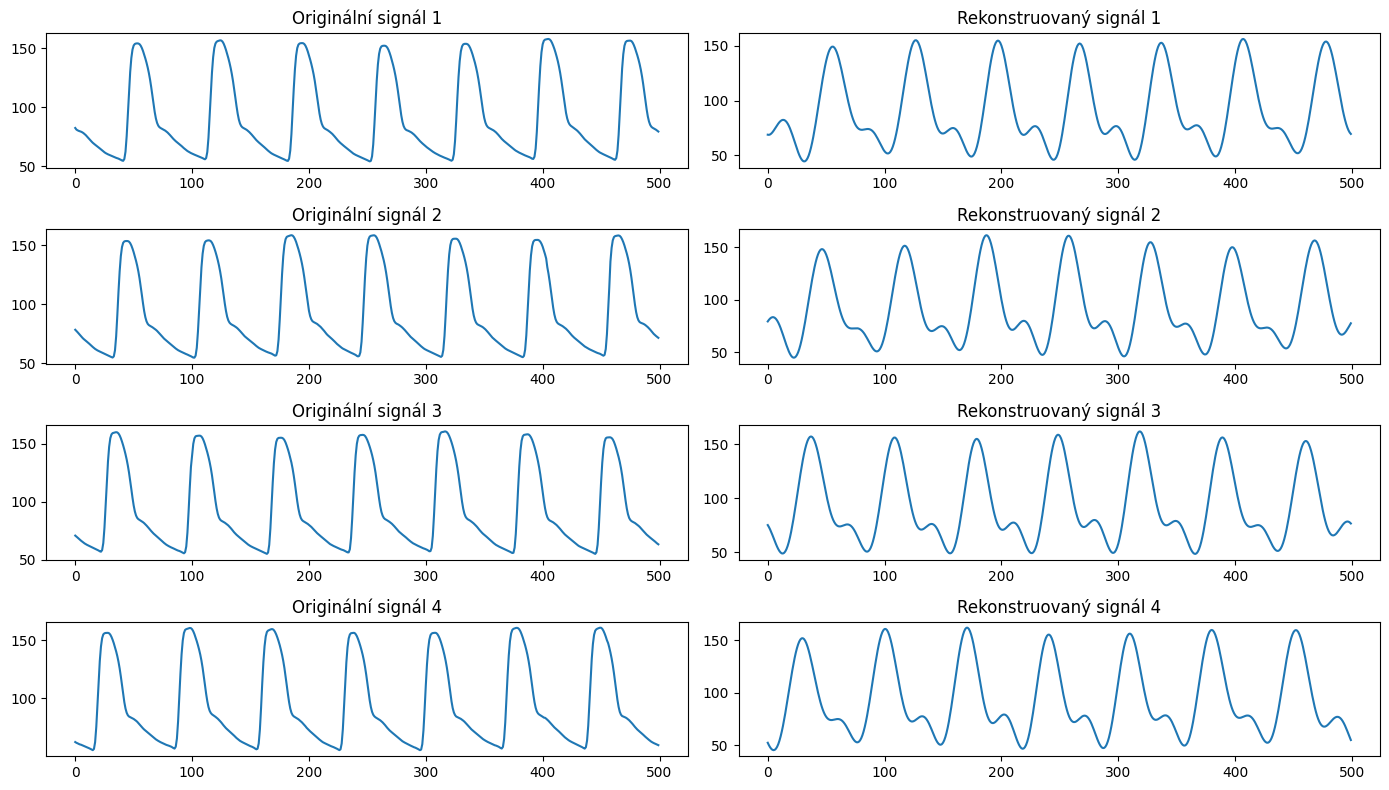

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lib.loader import SingleFileExtractor, FolderExtractor, Segment

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
OUTPUT_HDF5 = "spectrum/spectra_analysis.hdf5"
N_COMPONENTS = 16

# === POMOCNÉ FUNKCE ===
def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    all_data = np.concatenate([seg.data for seg in segments if seg.data is not None])
    return all_data

def compute_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            fft_cut = fft_vals[:n_components].copy()
            full_spectrum = np.zeros(window_size, dtype=complex)
            full_spectrum[:n_components] = fft_cut
            full_spectrum[-n_components+1:] = np.conj(fft_cut[1:][::-1])
            spectra.append((window.copy(), full_spectrum))
    return spectra

# === HLAVNÍ ANALÝZA ===
all_files = get_file_paths(HDF_PATH)
if not all_files:
    raise FileNotFoundError("Nebyl nalezen žádný HDF5 soubor v cílové složce.")

# Ověření a vytvoření cílové složky
output_dir = os.path.dirname(OUTPUT_HDF5) or "."
os.makedirs(output_dir, exist_ok=True)

with h5py.File(OUTPUT_HDF5, "w") as f:
    for file_path in all_files:
        print(f"Zpracovávám: {os.path.basename(file_path)}")
        try:
            signal = load_signal(file_path, HDF_PATH, SIGNAL_NAME)
            spectra_data = compute_spectra(signal, window_size=WINDOW_SIZE, n_components=N_COMPONENTS)
            dataset_name = os.path.splitext(os.path.basename(file_path))[0]
            original_windows = np.array([pair[0] for pair in spectra_data])
            spectra = np.array([pair[1] for pair in spectra_data])
            grp = f.create_group(dataset_name)
            grp.create_dataset("original", data=original_windows, dtype="float32")
            grp.create_dataset("spectra", data=spectra, dtype="complex64")
        except Exception as e:
            print(f"Chyba při zpracování {file_path}: {e}")

print(f"Spektrální analýza dokončena. Výsledky uloženy v {OUTPUT_HDF5}.")

# === UKÁZKOVÝ LOADER STRUKTURY ===
def inspect_hdf5_structure(hdf5_path):
    with h5py.File(hdf5_path, "r") as f:
        print("\nStruktura HDF5 souboru:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"- Dataset: {name}, shape={obj.shape}, dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"- Group: {name}")
        f.visititems(print_structure)

        print("\nUkázka hodnot z prvního datasetu:")
        first_group = list(f.keys())[0]
        print(f"→ Group: {first_group}")
        print("Original window:", f[first_group]["original"][:1])
        print("Spectrum window:", f[first_group]["spectra"][:1])

# Spusť inspekci
inspect_hdf5_structure(OUTPUT_HDF5)

# === REKONSTRUKCE SPEKTER A ORIGINÁLU ===
def reconstruct_signals_with_originals(hdf5_path, n=4):
    with h5py.File(hdf5_path, "r") as f:
        first_group = list(f.keys())[0]
        spectra = f[first_group]["spectra"][:n]
        originals = f[first_group]["original"][:n]
        print(spectra.shape, originals.shape)

    reconstructed_signals = [np.fft.ifft(spectrum).real for spectrum in spectra]

    plt.figure(figsize=(14, 8))
    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.plot(originals[i])
        plt.title(f"Originální signál {i+1}")

        plt.subplot(n, 2, 2 * i + 2)
        plt.plot(reconstructed_signals[i])
        plt.title(f"Rekonstruovaný signál {i+1}")

    plt.tight_layout()
    plt.show()

# Spusť porovnání originál vs rekonstrukce
reconstruct_signals_with_originals(OUTPUT_HDF5, n=4)
